# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal, stats
from cycler import cycler
from scipy.optimize import curve_fit

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
#%matplotlib notebook

# Data structure

In [3]:
# N_scal = 128
# scalars = [{'Sc': 500.0, 'N': N_scal}, 
#         {'Sc': 550.0, 'N': N_scal},
#         {'Sc': 600.0, 'N': N_scal},
#         {'Sc': 700.0, 'N': N_scal},
#         {'Sc': 750.0, 'N': N_scal},
#         {'Sc': 800.0, 'N': N_scal},
#         {'Sc': 900.0, 'N': N_scal}]

In [4]:
# N_scal = 128
# scalars = [{'Sc': 2.0, 'N': N_scal}, 
#         {'Sc': 5.0, 'N': N_scal},
#         {'Sc': 10.0, 'N': N_scal},
#         {'Sc': 20.0, 'N': N_scal},
#         {'Sc': 50.0, 'N': N_scal},
#         {'Sc': 100.0, 'N': N_scal},
#         {'Sc': 500.0, 'N': N_scal}]

In [5]:
N_scal = 128
scalars = [{'Sc': 20.0, 'N': N_scal}, 
        {'Sc': 50.0, 'N': N_scal},
        {'Sc': 75.0, 'N': N_scal},
        {'Sc': 100.0, 'N': N_scal},
        {'Sc': 200.0, 'N': N_scal},
        {'Sc': 300.0, 'N': N_scal},
        {'Sc': 500.0, 'N': N_scal}]

In [37]:
eps = 1.0
viscosity = 1.0
N = 128
D0 = 8.3650976202353233E-003
f = 4
A = 2.9340591730667147

In [7]:
for sca in range(len(scalars)) :
    scalars[sca].update({'diffusivity': viscosity/scalars[sca]["Sc"]})

# Reading data

In [8]:
#read correlation files
def read_data_file(common_folder, scalar, file_type, spec_type, spec_component, run_files) :
    nb_of_runs = len(run_files)
    for run_index in list(range(nb_of_runs)) :
        folder = common_folder + "run" + "%01d" % (run_index+1) + "/"
        if (run_files[run_index] < 1000) :
            file = folder + "scalar%01d" %scalar + "_" + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
        else : 
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
        file_data = []
        print('reading file: ' + file)
        averaging_weight = (run_files[run_index]+1)/(sum(run_files)+nb_of_runs)
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                temp_array_line=list(map(float, line.split( )))
                temp_array_line = [t * averaging_weight for t in temp_array_line]
                file_data.append(temp_array_line)  
        if (run_index == 0) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    k = np.array(accumulated_data[0])
    nb_of_modes = np.array(accumulated_data[1])
    average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
    for i in list(range(average_data.shape[0])) : 
        average_data[i, :] = np.array(accumulated_data[i+2])
    t = average_data[:,0]
    numpy_file_table = np.array(average_data[:,1:])
    return [k, nb_of_modes, t, numpy_file_table]

In [9]:
# read velocity spectrum file
def read_spec_file(common_folder, forlder_in, quantity, spec_type, ite) :
    file = common_folder + forlder_in + quantity + "_" + spec_type + "_ite=%06d" % ite + ".table"
    print('reading file: ' + file)
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)  
    spec_table = np.array(file_data)
    k = spec_table[:,0]
    nb_of_modes = spec_table[:,1]
    Ek = spec_table[:,2]
#     Exx = spec_table[:,3]
#     Eyy = spec_table[:,4]
#     Ezz = spec_table[:,5]
    #return [k, nb_of_modes, Ek, Exx, Eyy, Ezz, spec_table[:,6], spec_table[:,7], spec_table[:,8], spec_table[:,9]]
    return [k, nb_of_modes, Ek]

In [10]:
common_folder = "/home/gorbunov8a/data/random_advection/kappa_dep/test3/"
spec_type = "lin"
spec_component = "avg"
file_type = "two_point_corr_complex"
#run_windows = [29,27,31,41]
run_windows = [34]

In [11]:
# read data files
for sca in range(len(scalars)) : 
    [k, nb_of_modes, time, two_point_corr] = read_data_file(common_folder, sca+1, file_type, spec_type, spec_component, run_windows)
    [k, nb_of_modes, S2] = read_spec_file(common_folder, "run1/", "spectrum_scalar%1.0f" % (sca+1), "lin", 133000)
    scalars[sca].update({'corr': two_point_corr, 'scal_spec' : S2})

reading file: /home/gorbunov8a/data/random_advection/kappa_dep/test3/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=034.table
reading file: /home/gorbunov8a/data/random_advection/kappa_dep/test3/run1/spectrum_scalar1_lin_ite=133000.table
reading file: /home/gorbunov8a/data/random_advection/kappa_dep/test3/run1/scalar2_two_point_corr_complex_lin_Cavg_wi=034.table
reading file: /home/gorbunov8a/data/random_advection/kappa_dep/test3/run1/spectrum_scalar2_lin_ite=133000.table
reading file: /home/gorbunov8a/data/random_advection/kappa_dep/test3/run1/scalar3_two_point_corr_complex_lin_Cavg_wi=034.table
reading file: /home/gorbunov8a/data/random_advection/kappa_dep/test3/run1/spectrum_scalar3_lin_ite=133000.table
reading file: /home/gorbunov8a/data/random_advection/kappa_dep/test3/run1/scalar4_two_point_corr_complex_lin_Cavg_wi=034.table
reading file: /home/gorbunov8a/data/random_advection/kappa_dep/test3/run1/spectrum_scalar4_lin_ite=133000.table
reading file: /home/gorbunov8a/data/random_a

In [12]:
[k_vel, nb_of_modes_vel, Ek] = read_spec_file(common_folder, "run1/", "vel_spec", "lin", 133000)

reading file: /home/gorbunov8a/data/random_advection/kappa_dep/test3/run1/vel_spec_lin_ite=133000.table


# Parameters

In [13]:
# Plotting options
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=14)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

In [14]:
kmin = 8
kmax = np.max(k)-6
nb_of_curves = 9
step = round((kmax - kmin)/nb_of_curves)
indices_of_k_to_plot = np.arange(kmin,kmax,step, dtype=np.int16)
print(indices_of_k_to_plot)

[ 8 14 20 26 32 38 44 50 56]


In [15]:
def peclet(D0, l, kappa, epsilon) :
    return D0*(l**epsilon)/kappa

In [16]:
#Scalar forcing length scale :
scalar_L = 2.0*np.pi/3.5

In [17]:
for sca in scalars :
    sca['Pe'] = peclet(D0, scalar_L, sca['diffusivity'], 1.0)
    print(sca['Pe'])

0.3003397626319172
0.7508494065797929
1.1262741098696893
1.5016988131595859
3.0033976263191717
4.505096439478757
7.5084940657979296


In [18]:
def diffusion_length_scale(D0, kappa, epsilon) :
    return (kappa/D0)**(1.0/epsilon)

In [19]:
def kappa_ren(kappa,D0,A, d) :
    return (kappa + 1.0/(2.0*d)*D0*A*3.0)

In [42]:
for sca in scalars :
    sca['rd'] = diffusion_length_scale(D0, sca['diffusivity'], 1.0)
    sca['kappa_ren'] =kappa_ren(sca['diffusivity'], D0, A, 3)
    print(sca['kappa_ren'])

0.062271845703125
0.032271845703124996
0.02560517903645833
0.022271845703124998
0.017271845703124997
0.015605179036458331
0.014271845703124997


In [43]:
Te = 4.*(time[1]-time[0])
Urms = 6.16
tau0 = scalar_L/Urms
print(Te/tau0)
print(tau0)

0.006737502029683499
0.2914278899433945


# Spectra

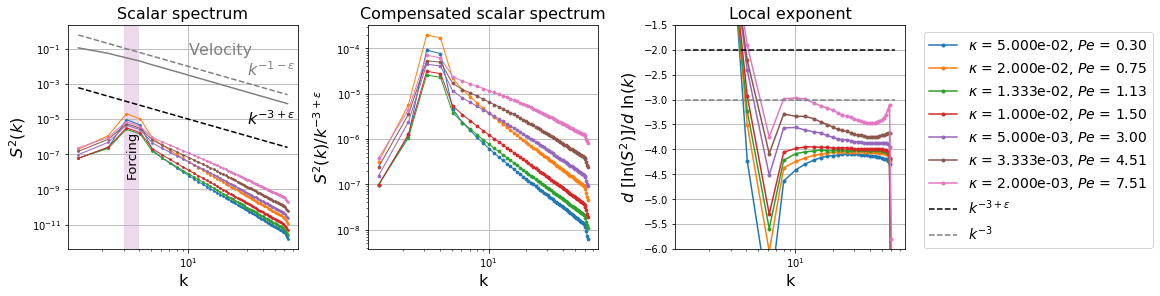

In [21]:
fig, ax = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(16,4))

resampling = 2
sl = np.s_[1:-2:resampling]
spherical_coef = 4.0*np.pi*k**2/nb_of_modes

for i, sca in enumerate(scalars) :
    ax[0].plot(k, (sca["scal_spec"])*spherical_coef, '.-', lw=1.0, markersize=3.5)
    ax[1].plot(k, (sca["scal_spec"])*spherical_coef/(k**(-3+eps)), '.-', lw=1.0, markersize=5.5, \
               label=r'$\kappa$ = %2.3e, $Pe$ = %2.2f' % (sca['diffusivity'], sca['Pe']))
    
    slope = np.gradient(np.log(sca['scal_spec']*spherical_coef)[sl], np.log(k[sl]))
    ax[2].plot(k[sl], slope, '.-', label=r'$\kappa$ = %2.3e, $Pe$ = %2.2f' % (sca['diffusivity'], sca['Pe']))
ax[0].plot(k,10e-4*k**(-3+eps), 'k--'); ax[0].annotate(r'$k^{-3+\epsilon}$', xy=(30, 0.5e-5), xycoords='data', size='16', color='k')
ax[0].plot(k_vel, 10e-2*Ek/np.max(Ek)*4.0*np.pi*(k_vel**2)/nb_of_modes_vel, color='gray'); ax[0].annotate(r'Velocity', xy=(10, 5e-2), xycoords='data', size='16', color='gray')
ax[0].plot(k,10e-1*k**(-1-eps), '--', color='gray'); ax[0].annotate(r'$k^{-1-\epsilon}$', xy=(30, 0.3e-2), xycoords='data', size='16', color='gray')
ax[0].axvspan(3.0, 4.0, facecolor='purple', alpha=0.15)
ax[0].text(3.5, 10e-8, "Forcing", {'color': 'black', 'fontsize': 13},
         horizontalalignment='center',
         verticalalignment='center',
         rotation=90,
         clip_on=False)
ax[0].set(xscale='log', yscale='log', xlabel='k', ylabel=r'$S^2(k)$', title=r'Scalar spectrum'); ax[0].grid()

ax[1].set(xscale='log', yscale='log', xlabel='k', ylabel=r'$S^2(k)/k^{-3+\epsilon}$', title=r'Compensated scalar spectrum'); ax[1].grid()

ax[2].plot(k, np.full_like(k, (-3.0+eps), dtype=float), '--', label=r'$k^{-3+\epsilon}$',color='k')
ax[2].plot(k, np.full_like(k, (-3.0), dtype=float), '--', label=r'$k^{-3}$',color='gray')
ax[2].set(xscale='log', yscale='linear', title='Local exponent', xlabel='k', ylabel=r'$d\ [\ln(S^2)]/d\ \ln (k)$'); ax[2].grid()
ax[2].set(ylim=[-6,-1.5])
lgd = ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#pp = PdfPages('../Images/Scalar/eps1_N128_7sca_spec_scalar.pdf')
#pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
#pp.close()

plt.show()

# 2-point time correlations

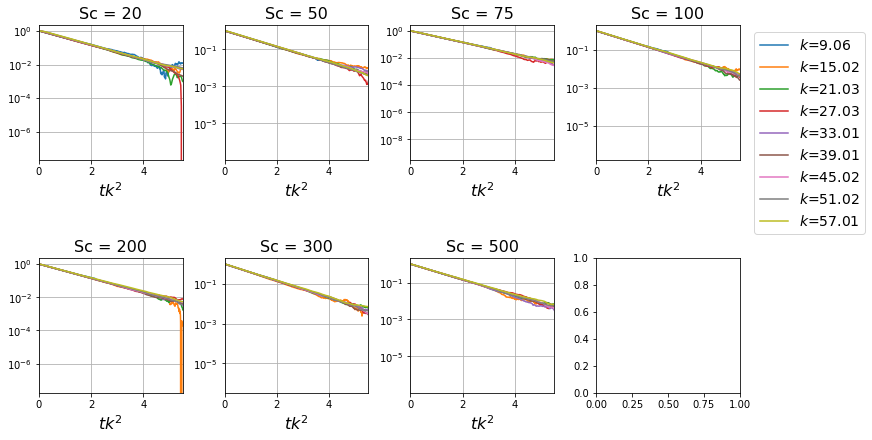

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=4, constrained_layout=True,figsize=(12,6), squeeze=False)
for index, sca in np.ndenumerate(scalars) :
    row = index[0]//4; col = index[0] - (row*4)
    for ik in indices_of_k_to_plot :
        ax[row,col].plot(sca['kappa_ren']*time*k[ik]**2, sca['corr'][:,ik]/sca['corr'][0,ik], '-', label=r'$k$=%2.2f' % (k[ik]))
    ax[row,col].set(xscale='linear',yscale='log', xlabel=r'$t k^2$', title=r'Sc = %01d' % (sca['Sc'])); ax[row,col].grid()
    ax[row,col].set(xlim=[0,5.5])
ax[0,3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Fit

In [23]:
def simple_gaussian(x, a, c):   
    return np.exp(-a * (x)**2.0 + c) 
def simple_gaussian_jacobian(x, a, c):   
    return np.transpose([-(x**2.0)*np.exp(-a * (x)**2.0 + c), np.exp(-a * (x)**2.0 + c)])

def simple_exp(x, a, c):   
    return np.exp(-a * x + c) 
def simple_exp_jacobian(x, a, c):   
    return np.transpose([-x*np.exp(-a * x + c), np.exp(-a * x + c)])

def linear_fun(x, a, b):   
    return (a * x + b) 
def linear_jacobian(x, a, b):   
    return np.transpose([x, np.ones_like(x)])

In [24]:
tk2_end_fit = 2.0
min_coef = 5
for simu in scalars :
    N = len(time); Nmin = N//min_coef; Nmax = N-5
    simu['a'] = np.zeros_like(k, dtype=float); simu['c'] = np.zeros_like(k, dtype=float)
    simu['a_std_error'] = np.zeros_like(k, dtype=float); simu['c_std_error'] = np.zeros_like(k, dtype=float)
    a = f
    for ik in list(range(len(k))) : 
        b = np.searchsorted(simu['kappa_ren']*time*(k[ik]**2), tk2_end_fit)
#         end_of_fit = np.where(simu['corr'][:,ik] < 0)
#         if len(end_of_fit[0]) > 0 :
#             b = end_of_fit[0][0]-1
#         else :
#             b = Nmax
        coef, covar = curve_fit(simple_exp, time[a:b], simu['corr'][a:b,ik]/simu['corr'][1,ik], jac=simple_exp_jacobian, absolute_sigma=False)
        [simu['a'][ik], simu['c'][ik]] = coef
        simu['a_std_error'][ik], simu['c_std_error'][ik] = np.sqrt(np.diag(covar))

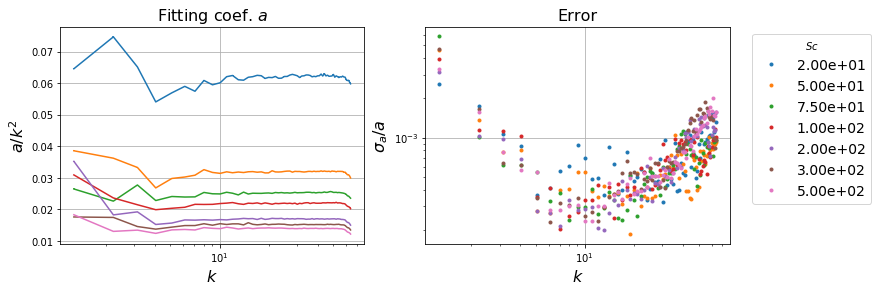

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sl=np.s_[0::]
for simu in scalars :
    ax[0].errorbar(k[sl], (simu['a']/k**2)[sl], yerr=(simu['a_std_error']/k**2)[sl])
    ax[1].plot(k, simu['a_std_error']/simu['a'], '.', label=r'%2.2e' % simu['Sc'])
ax[0].set(xlabel=r'$k$', ylabel=r'$a/k^2$', xscale='log', yscale='linear', title=r'Fitting coef. $a$'); ax[0].grid()
ax[1].set(xlabel=r'$k$', ylabel=r'$\sigma_a/a$', xscale='log', yscale='log', title=r'Error'); ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$Sc$')
plt.show()

In [26]:
def find_plateau(data) :
    N = len(data)
    Nmin = N//2
    a = 0; b = N-1
    minAlign = np.max(data-np.mean(data))/np.float(b-a+1)
    for i in list(range(0, N-Nmin-1)) :
        for j in list(range(i+Nmin, N-1)) :
            newAlign = np.max(data[i:j]-np.mean(data[i:j]))/np.float(j-i+1)
            if (newAlign < minAlign) :
                minAlign = newAlign
                a = i; b = j
    return np.mean(data[a:b]), np.std(data[a:b]), (b-a+1), a, b

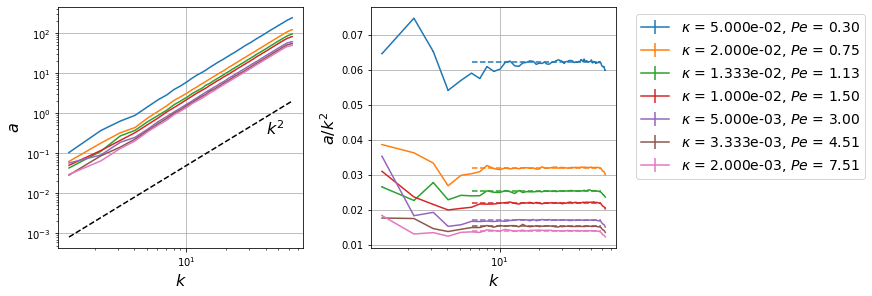

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), constrained_layout=True)
for i, sca in enumerate(scalars) :
    sl = np.s_[5:-5:]

    ax[0].errorbar(k, sca['a'], yerr=sca['a_std_error'], label=r'$\kappa$ = %2.3e, $Pe$ = %2.2f' % (sca['diffusivity'], sca['Pe']))

    sca['plateau_a'] = find_plateau(sca['a'][sl]/(k[sl]**2))[0]
    sca['std_err_plateau_a'] = np.sqrt(np.sum((sca['a'][sl]/(k[sl]**2)-sca['plateau_a'])**2)/len(k[sl]-1))
    ax[1].errorbar(k, sca['a']/(k**2), yerr=sca['a_std_error']/(k**2), \
                   label=r'$\kappa$ = %2.3e, $Pe$ = %2.2f' % (sca['diffusivity'], sca['Pe']), color=colors[i])
    ax[1].plot(k[sl], np.full_like(k[sl], sca['plateau_a']), '--', color=colors[i])

ax[0].plot(k, 5e-4*k**2, 'k--')
ax[0].annotate(r'$k^2$', xy=(40, 0.3), xycoords='data', size='16')
ax[0].set(xscale='log', yscale='log', xlabel=r'$k$', ylabel=r'$a$'); ax[0].grid()
#ax.set(ylim=[5e2,10e6])
ax[1].set(xscale='log', yscale='linear', xlabel=r'$k$', ylabel=r'$a/k^2$'); ax[1].grid()
lgd = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#pp = PdfPages('../Images/Scalar/eps1_N128_7sca_corr_fit_vs_k.pdf')
#pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
#pp.close()

plt.show()

# Dependence on $\kappa$

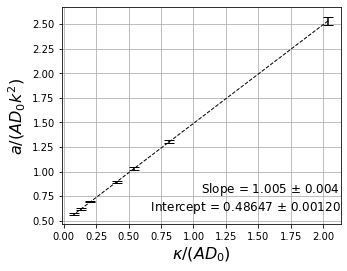

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
x = np.array([(simu['diffusivity']/D0/A) for simu in scalars])
y = [(simu['plateau_a']/D0/A) for simu in scalars]
yerr = [(simu['std_err_plateau_a']/D0/A) for simu in scalars]

coef, covar = curve_fit(linear_fun, x, y, sigma = yerr, jac=linear_jacobian, absolute_sigma=False)
[slope, intercept]=coef; [slope_stderr,intercept_stderr]=np.sqrt(np.diag(covar))

ax.errorbar(x,y, yerr=yerr, ls='', capsize=5, color='k')
ax.plot(x, intercept + slope*x, '--', label='fitted line', color='k', lw=1)
ax.text(1.0, 0.2, 'Slope = %2.3f $\pm$ %2.3f \n Intercept = %1.5f $\pm$ %1.5f' % (slope, slope_stderr, intercept, intercept_stderr), {'color': 'k', 'fontsize': 12}, va="top", ha="right", transform=plt.gca().transAxes)

ax.set(xlabel=r'$\kappa/(A D_0)$', ylabel=r'$a/(A D_0 k^2)$'); ax.grid()

#pp = PdfPages('../Images/Scalar/eps1_N128_7sca_correlation_fit_vs_kappa.pdf')
#pp.savefig(bbox_extra_artists=(), bbox_inches='tight')
#pp.close()

plt.show()

# Physical fields

In [29]:
# import h5py
# # Read velocity fields
# file = h5py.File(common_folder + 'run1/' + 'U_120000.h5', 'r')
# U_vel = file['U'][:,:]
# file.close()
# # Read scalar fields
# for sca in range(len(scalars)) :
#     simu = scalars[sca]
#     file = h5py.File(common_folder + 'run1/' + 'ScalarS%1.0f' % (sca+1) + '_120000.h5', 'r')
#     simu['scal_field'] = file['ScalarS%1.0f' % (sca+1)][:,:] # copy the file data into a numpy array
#     file.close()

In [30]:
# nb_of_rows = 2
# nb_of_columns = 4
# table = np.arange(len(scalars)+1).reshape(nb_of_rows,nb_of_columns)

# fig, ax = plt.subplots(nrows=nb_of_rows, ncols=nb_of_columns, figsize=(nb_of_columns*4,nb_of_rows*4), squeeze=False, constrained_layout=True)
# x_cut=30

# for index, isimu in np.ndenumerate(table):
#     if (isimu < len(scalars)) : 
#         simu = scalars[isimu]
#         x_scal = 2.0*np.pi/simu['N']*np.arange(0,simu['N'])
#         im = ax[index].pcolormesh(x_scal, x_scal, simu['scal_field'][x_cut, :,:], cmap='jet')
#         ax[index].set(xscale='linear', yscale='linear', title=r'$\kappa = $ %2.2e, $Pe$ = %2.2f' % (simu['diffusivity'], simu['Pe']))
#         fig.colorbar(im, ax=ax[index], aspect=100)
#     if (index[0] == 1) : ax[index].set(xlabel=r'$y$')
#     if (index[1] == 0) : ax[index].set(ylabel=r'$z$')
# im = ax[nb_of_rows-1,nb_of_columns-1].pcolormesh(x_scal, x_scal, U_vel[x_cut, :,:], cmap='jet')
# ax[nb_of_rows-1,nb_of_columns-1].set(xscale='linear', yscale='linear', title=r'Velocity $U$')
# fig.colorbar(im, ax=ax[nb_of_rows-1,nb_of_columns-1], aspect=100)
# #plt.savefig("../Images/Scalar/eps1_N128_diff_D0_fields.png", dpi=150, format="png")
# plt.show()

In [31]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
# #plot histogram
# nb_of_bins=50
# simu = scalars[0]
# ax.hist(x=simu['scal_field'].flatten(), bins=nb_of_bins, histtype='step', density=True, log=True, align='mid', label='Scalar %01d' % (index[0] + 1))
# #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.set(title='PDF of scalar'); ax.grid()
# plt.show()

# Plots for paper

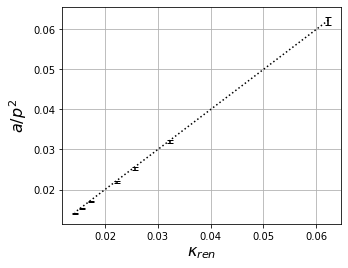

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
sl = np.s_[0:]

x = [kappa_ren(simu['diffusivity'],D0,A,3) for simu in scalars[sl]]
y = [simu['plateau_a'] for simu in scalars[sl]]
yerr = [simu['std_err_plateau_a'] for simu in scalars[sl]]
ax.errorbar(x,y, yerr=yerr, ls='', ms=3, elinewidth=1.5, capsize=3.0, color='k')
ax.set(xlabel=r'$\kappa_{ren}$', ylabel=r'$a/p^2$', xscale='linear', yscale='linear'); ax.grid()
ax.plot(x,x,'k:')

# pp = PdfPages('../Images/Scalar/Sc500_diff_D0_corr_fit_vs_D0.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

In [33]:
print(yerr)

[0.0009963473157562697, 0.0003493983994827673, 0.000316367613548294, 0.0002405721018335304, 0.00014853903575870635, 0.00014780002891636712, 0.00014720555057823377]


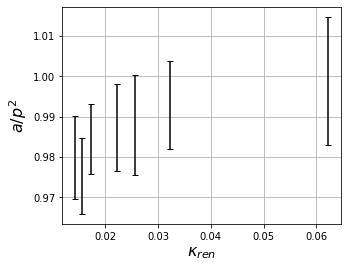

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
sl = np.s_[0:]

x = [kappa_ren(simu['diffusivity'],D0,A,3) for simu in scalars[sl]]
y = [simu['plateau_a'] for simu in scalars[sl]]
yerr = [simu['std_err_plateau_a'] for simu in scalars[sl]]
ax.errorbar(x,np.array(y)/np.array(x), yerr=np.array(yerr)/np.array(x), ls='', ms=3, elinewidth=1.5, capsize=3.0, color='k')
ax.set(xlabel=r'$\kappa_{ren}$', ylabel=r'$a/p^2$', xscale='linear', yscale='linear'); ax.grid()
#ax.plot(x,x,'k:')

# pp = PdfPages('../Images/Scalar/Sc500_diff_D0_corr_fit_vs_D0.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

In [35]:
[kappa_ren(simu['diffusivity'],D0,A,3) for simu in scalars[sl]]

[0.062271845703125,
 0.032271845703124996,
 0.02560517903645833,
 0.022271845703124998,
 0.017271845703124997,
 0.015605179036458331,
 0.014271845703124997]

In [36]:
[simu['Pe'] for simu in scalars[sl]]

[0.3003397626319172,
 0.7508494065797929,
 1.1262741098696893,
 1.5016988131595859,
 3.0033976263191717,
 4.505096439478757,
 7.5084940657979296]